RBF and MMDLoss classes are copied from https://github.com/yiftachbeer/mmd_loss_pytorch with some changes

In [167]:
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm 
from scipy.stats import lognorm

In [168]:
class RBF(nn.Module):

    def __init__(self, bandwidth=None): #bandwidth = sigma
        super().__init__()
        self.bandwidth_multipliers = torch.tensor([0.5, 1, 5, 10, 20, 40], dtype = torch.float32)
        self.bandwidth = bandwidth

    def get_bandwidth(self):
        if self.bandwidth is None:
            return 1
        return self.bandwidth

    def forward(self, X):
        L2_distances = torch.cdist(X, X) ** 2 
        return torch.exp(-0.5 * L2_distances[None, ...] / ((self.get_bandwidth() * self.bandwidth_multipliers)**2)[:, None, None]).sum(dim=0) - 6*torch.eye(len(X), dtype=torch.float32)

class MMDLoss(nn.Module):

    def __init__(self, kernel=RBF()):
        super().__init__()
        self.kernel = kernel

    def forward(self, X, Y):
        K = self.kernel(torch.vstack([X, Y]))

        X_size = X.shape[0]
        Y_size = Y.shape[0]
        XX = K[:X_size, :X_size].sum() / (X_size**2-X_size)
        XY = K[:X_size, X_size:].mean()
        YY = K[X_size:, X_size:].sum() / (Y_size**2-Y_size)
        return XX - 2 * XY + YY 
    
class Laplacian(nn.Module):

    def __init__(self, bandwidth=None): #bandwidth = gamma
        super().__init__()
        self.bandwidth_multipliers = torch.tensor([0.5, 1, 5, 10, 20, 40], dtype = torch.float32)
        self.bandwidth = bandwidth

    def get_bandwidth(self):
        if self.bandwidth is None:
            return 1
        return self.bandwidth

    def forward(self, X):
        L1_distances = torch.cdist(X, X, p = 1) 
        return torch.exp(-L1_distances[None, ...] * (self.get_bandwidth() * self.bandwidth_multipliers)[:, None, None]).sum(dim=0) - 6*torch.eye(len(X), dtype=torch.float32)
    

class RQ(nn.Module):

    def __init__(self):
        super().__init__()
        self.alpha = torch.tensor([0.25,0.5,1,2,5,10], dtype = torch.float32) 

    def forward(self, X):
        L2_distances = torch.cdist(X, X) ** 2 
        return ((1+L2_distances[None, ...] / (2 * self.alpha)[:, None, None])**-self.alpha[:,None,None]).sum(dim=0) - 6*torch.eye(len(X), dtype=torch.float32)
    
class EnergyDistance(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, X, Y):
        data = torch.vstack([X, Y])
        L2_distances = torch.cdist(data, data)

        X_size = X.shape[0]
        Y_size = Y.shape[0]
        XX = L2_distances[:X_size, :X_size].sum()/(X_size**2-X_size)
        XY = L2_distances[:X_size, X_size:].mean()
        YY = L2_distances[X_size:, X_size:].sum()/(Y_size**2-Y_size)
        return -0.5*XX + XY -0.5*YY

Training data:

In [169]:
np.random.seed(0)

N = 20000
x1 = np.random.uniform(0,1,N)
x2 = np.random.uniform(0,1,N)
i = [0]*N #stds
for j in range(N):
    if x1[j] > 0.5: i[j] = 1
    else: i[j] = 0.5
y = (x1 + x2)*np.exp(np.random.normal(0,i,N))
X_input = np.column_stack((x1,x2))

X_input = torch.tensor(X_input, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

#standardize
X_means = X_input.mean(dim=0, keepdim=True)
X_stds = X_input.std(dim=0, keepdim=True)
X_input = (X_input) / X_stds

Define and train MMD network with RBF kernel:

In [170]:
np.random.seed(1)
torch.manual_seed(0)

N_input = 100 #number of uniform inputs
class network(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(X_input.shape[1]+N_input, 200)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(200, 200)
        self.act2 = nn.ReLU()
        self.hidden3 = nn.Linear(200, 100)
        self.act3 = nn.ReLU()
        self.hidden4 = nn.Linear(100, 100)
        self.act4 = nn.ReLU()
        self.output = nn.Linear(100, 1)
 
    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act3(self.hidden3(x))
        x = self.act4(self.hidden4(x))
        x = self.output(x)
        return x
    
model = network()

loss_fn = MMDLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

n_epochs = 150 
batch_size = 400 

losses = []
for epoch in range(n_epochs):
    shuffle = torch.randperm(len(y))
    y = y[shuffle]
    X_input = X_input[shuffle]
    for i in range(0, len(y), batch_size):
        Xbatch = X_input[i:i+batch_size]
        x = np.random.uniform(-0.5,0.5,batch_size*N_input)
        x = torch.tensor(x, dtype=torch.float32).reshape(batch_size, N_input)
        X_model = torch.column_stack([Xbatch,x])
        y_pred = model(X_model)
        ybatch = y[i:i+batch_size] 
        pred = torch.column_stack([Xbatch,y_pred])
        real = torch.column_stack([Xbatch,ybatch])
        loss = loss_fn(pred, real)
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        losses.append(loss)
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 0.007421970367431641
Finished epoch 1, latest loss 0.005133628845214844
Finished epoch 2, latest loss -0.0009589195251464844
Finished epoch 3, latest loss -0.0005993843078613281
Finished epoch 4, latest loss -0.005067348480224609
Finished epoch 5, latest loss 0.0045299530029296875
Finished epoch 6, latest loss -0.0015788078308105469
Finished epoch 7, latest loss -0.0021820068359375
Finished epoch 8, latest loss -0.00327301025390625
Finished epoch 9, latest loss -0.005383968353271484
Finished epoch 10, latest loss -0.004042148590087891
Finished epoch 11, latest loss -0.005469322204589844
Finished epoch 12, latest loss 0.004057407379150391
Finished epoch 13, latest loss -0.006428718566894531
Finished epoch 14, latest loss -0.005052089691162109
Finished epoch 15, latest loss 0.0034513473510742188
Finished epoch 16, latest loss -0.006237506866455078
Finished epoch 17, latest loss -0.005837917327880859
Finished epoch 18, latest loss -0.0012578964233398438
Finis

Train MMD network with laplacian kernel:

In [171]:
np.random.seed(1)
torch.manual_seed(0)
    
model_Laplacian = network()

loss_fn_Laplacian = MMDLoss(kernel=Laplacian())
optimizer_Laplacian = optim.RMSprop(model_Laplacian.parameters(), lr=0.001)

n_epochs = 150 
batch_size = 400 

for epoch in range(n_epochs):
    shuffle = torch.randperm(len(y))
    y = y[shuffle]
    X_input = X_input[shuffle]
    for i in range(0, len(y), batch_size):
        Xbatch = X_input[i:i+batch_size]
        x = np.random.uniform(-0.5,0.5,batch_size*N_input)
        x = torch.tensor(x, dtype=torch.float32).reshape(batch_size, N_input)
        X_model = torch.column_stack([Xbatch,x])
        y_pred = model_Laplacian(X_model)
        ybatch = y[i:i+batch_size] 
        pred = torch.column_stack([Xbatch,y_pred])
        real = torch.column_stack([Xbatch,ybatch])
        loss = loss_fn_Laplacian(pred, real)
        optimizer_Laplacian.zero_grad()
        loss.backward() 
        optimizer_Laplacian.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss -0.001164466142654419
Finished epoch 1, latest loss -0.00308990478515625
Finished epoch 2, latest loss -0.0022985339164733887
Finished epoch 3, latest loss -0.0016699433326721191
Finished epoch 4, latest loss -0.006467670202255249
Finished epoch 5, latest loss -0.000380784273147583
Finished epoch 6, latest loss -0.00399431586265564
Finished epoch 7, latest loss -0.004797816276550293
Finished epoch 8, latest loss -0.005835175514221191
Finished epoch 9, latest loss -0.000730663537979126
Finished epoch 10, latest loss -0.007048547267913818
Finished epoch 11, latest loss -0.006581634283065796
Finished epoch 12, latest loss -0.003927737474441528
Finished epoch 13, latest loss -0.006373554468154907
Finished epoch 14, latest loss -0.00569605827331543
Finished epoch 15, latest loss -0.006645381450653076
Finished epoch 16, latest loss -0.004202753305435181
Finished epoch 17, latest loss -0.006213933229446411
Finished epoch 18, latest loss -0.0018954575061798096
Fin

Train MMD network with RQ kernel:

In [172]:
np.random.seed(1)
torch.manual_seed(0)
    
model_RQ = network()

loss_fn_RQ = MMDLoss(kernel=RQ())
optimizer_RQ = optim.RMSprop(model_RQ.parameters(), lr=0.001)

n_epochs = 150 
batch_size = 400 

for epoch in range(n_epochs):
    shuffle = torch.randperm(len(y))
    y = y[shuffle]
    X_input = X_input[shuffle]
    for i in range(0, len(y), batch_size):
        Xbatch = X_input[i:i+batch_size]
        x = np.random.uniform(-0.5,0.5,batch_size*N_input)
        x = torch.tensor(x, dtype=torch.float32).reshape(batch_size, N_input)
        X_model = torch.column_stack([Xbatch,x])
        y_pred = model_RQ(X_model)
        ybatch = y[i:i+batch_size] 
        pred = torch.column_stack([Xbatch,y_pred])
        real = torch.column_stack([Xbatch,ybatch])
        loss = loss_fn_RQ(pred, real)
        optimizer_RQ.zero_grad() 
        loss.backward() 
        optimizer_RQ.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss -0.0014243125915527344
Finished epoch 1, latest loss 0.007174491882324219
Finished epoch 2, latest loss 0.0032112598419189453
Finished epoch 3, latest loss -0.008359670639038086
Finished epoch 4, latest loss -0.008797526359558105
Finished epoch 5, latest loss -0.0008671283721923828
Finished epoch 6, latest loss -0.009828567504882812
Finished epoch 7, latest loss -0.007536411285400391
Finished epoch 8, latest loss -0.005490779876708984
Finished epoch 9, latest loss -0.012887239456176758
Finished epoch 10, latest loss -0.009400367736816406
Finished epoch 11, latest loss 0.0016214847564697266
Finished epoch 12, latest loss 0.002850055694580078
Finished epoch 13, latest loss -0.007468104362487793
Finished epoch 14, latest loss -0.008979558944702148
Finished epoch 15, latest loss 0.012654542922973633
Finished epoch 16, latest loss -0.011616945266723633
Finished epoch 17, latest loss -0.010430574417114258
Finished epoch 18, latest loss -0.012375116348266602
Fini

Train energy distance network:

In [173]:
np.random.seed(1)
torch.manual_seed(0)
    
model_ED = network()

loss_fn_ED = EnergyDistance()
optimizer_ED = optim.RMSprop(model_ED.parameters(), lr=0.001)

n_epochs = 150 
batch_size = 400 

for epoch in range(n_epochs):
    shuffle = torch.randperm(len(y))
    y = y[shuffle]
    X_input = X_input[shuffle]
    for i in range(0, len(y), batch_size):
        Xbatch = X_input[i:i+batch_size]
        x = np.random.uniform(-0.5,0.5,batch_size*N_input)
        x = torch.tensor(x, dtype=torch.float32).reshape(batch_size, N_input)
        X_model = torch.column_stack([Xbatch,x])
        y_pred = model_ED(X_model)
        ybatch = y[i:i+batch_size] 
        pred = torch.column_stack([Xbatch,y_pred])
        real = torch.column_stack([Xbatch,ybatch])
        loss = loss_fn_ED(pred, real)
        optimizer_ED.zero_grad()
        loss.backward() 
        optimizer_ED.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 0.028338313102722168
Finished epoch 1, latest loss 0.006511688232421875
Finished epoch 2, latest loss 0.022187113761901855
Finished epoch 3, latest loss 0.006775021553039551
Finished epoch 4, latest loss 0.014114737510681152
Finished epoch 5, latest loss 0.0011254549026489258
Finished epoch 6, latest loss 0.019311070442199707
Finished epoch 7, latest loss 0.005970358848571777
Finished epoch 8, latest loss -0.0028508901596069336
Finished epoch 9, latest loss -0.0014647245407104492
Finished epoch 10, latest loss -0.0015331506729125977
Finished epoch 11, latest loss 0.009328126907348633
Finished epoch 12, latest loss 0.0104827880859375
Finished epoch 13, latest loss -0.003949403762817383
Finished epoch 14, latest loss -0.0037376880645751953
Finished epoch 15, latest loss 0.018416881561279297
Finished epoch 16, latest loss -0.004198789596557617
Finished epoch 17, latest loss -0.001356959342956543
Finished epoch 18, latest loss -0.003651261329650879
Finished ep

Test the four models.
Compute MSE for mean and quantiles, mean MMDs and energy distance

MMD network with RBF kernel:

In [174]:
np.random.seed(3)

MSE_means = []
MSE_quantiles = []
MSE_quantiles10 = []
MMD_RBF = []
MMD_Laplacian = []
MMD_RQ = []
ED = []

for i in np.arange(0.05,1,0.05):
    for j in np.arange(0.05,1,0.05):
        x = np.random.uniform(-0.5,0.5,1000*N_input)
        x = torch.tensor(x, dtype=torch.float32).reshape(1000, N_input)
        X_predict = torch.tensor([i,j]*1000, dtype=torch.float32).reshape(1000,2)
        X_predict = (X_predict) / X_stds
        X_predict = torch.column_stack([X_predict,x])
        with torch.no_grad(): 
            y_sample = model(X_predict)
        if i > 0.5: sigma = 1
        else: sigma = 0.5
        mylognorm = stats.lognorm(s = sigma, scale = i+j) #real distribution
        y_compare = (i + j)*np.exp(np.random.normal(0,sigma,1000))
        y_compare = torch.tensor(y_compare, dtype=torch.float32).reshape(-1, 1)
        MMD_RBF.append(loss_fn(y_sample,y_compare))
        MMD_Laplacian.append(loss_fn_Laplacian(y_sample,y_compare))
        MMD_RQ.append(loss_fn_RQ(y_sample,y_compare))
        ED.append(loss_fn_ED(y_sample,y_compare))
        y_sample = y_sample.reshape(1,-1).numpy()[0]
        MSE_means.append((mylognorm.mean() - np.mean(y_sample))**2)
        MSE_quantiles.append((mylognorm.ppf(0.9)-np.quantile(y_sample,0.9))**2)
        MSE_quantiles10.append((mylognorm.ppf(0.1)-np.quantile(y_sample,0.1))**2)
    print(i)

print(f'MSE of means: {np.mean(MSE_means)}')
print(f'MSE of 0.9 quantiles: {np.mean(MSE_quantiles)}')
print(f'MSE of 0.1 quantiles: {np.mean(MSE_quantiles10)}')
print(f'MMD with RBF kernel: {np.mean(MMD_RBF)}')
print(f'MMD with Laplacian kernel: {np.mean(MMD_Laplacian)}')
print(f'MMD with RQ kernel: {np.mean(MMD_RQ)}')
print(f'Energy distance: {np.mean(ED)}')

0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000001
0.7500000000000001
0.8
0.8500000000000001
0.9000000000000001
0.9500000000000001
MSE of means: 0.04332397266763042
MSE of 0.9 quantiles: 0.36617931277134896
MSE of 0.1 quantiles: 0.009880471393814374
MMD with RBF kernel: 0.007706479635089636
MMD with Laplacian kernel: 0.11768161505460739
MMD with RQ kernel: 0.013616926036775112
Energy distance: 0.0071420310996472836


MMD network with laplacian kernel:

In [175]:
np.random.seed(3)

MSE_means = []
MSE_quantiles = []
MSE_quantiles10 = []
MMD_RBF = []
MMD_Laplacian = []
MMD_RQ = []
ED = []

for i in np.arange(0.05,1,0.05):
    for j in np.arange(0.05,1,0.05):
        x = np.random.uniform(-0.5,0.5,1000*N_input)
        x = torch.tensor(x, dtype=torch.float32).reshape(1000, N_input)
        X_predict = torch.tensor([i,j]*1000, dtype=torch.float32).reshape(1000,2)
        X_predict = (X_predict) / X_stds
        X_predict = torch.column_stack([X_predict,x])
        with torch.no_grad(): 
            y_sample = model_Laplacian(X_predict)
        if i > 0.5: sigma = 1
        else: sigma = 0.5
        mylognorm = stats.lognorm(s = sigma, scale = i+j)
        y_compare = (i + j)*np.exp(np.random.normal(0,sigma,1000))
        y_compare = torch.tensor(y_compare, dtype=torch.float32).reshape(-1, 1)
        MMD_RBF.append(loss_fn(y_sample,y_compare))
        MMD_Laplacian.append(loss_fn_Laplacian(y_sample,y_compare))
        MMD_RQ.append(loss_fn_RQ(y_sample,y_compare))
        ED.append(loss_fn_ED(y_sample,y_compare))
        y_sample = y_sample.reshape(1,-1).numpy()[0]
        MSE_means.append((mylognorm.mean() - np.mean(y_sample))**2)
        MSE_quantiles.append((mylognorm.ppf(0.9)-np.quantile(y_sample,0.9))**2)
        MSE_quantiles10.append((mylognorm.ppf(0.1)-np.quantile(y_sample,0.1))**2)
    print(i)

print(f'MSE of means: {np.mean(MSE_means)}')
print(f'MSE of 0.9 quantiles: {np.mean(MSE_quantiles)}')
print(f'MSE of 0.1 quantiles: {np.mean(MSE_quantiles10)}')
print(f'MMD with RBF kernel: {np.mean(MMD_RBF)}')
print(f'MMD with Laplacian kernel: {np.mean(MMD_Laplacian)}')
print(f'MMD with RQ kernel: {np.mean(MMD_RQ)}')
print(f'Energy distance: {np.mean(ED)}')

0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000001
0.7500000000000001
0.8
0.8500000000000001
0.9000000000000001
0.9500000000000001
MSE of means: 0.01883383253864098
MSE of 0.9 quantiles: 0.1784634286517737
MSE of 0.1 quantiles: 0.003833887418238768
MMD with RBF kernel: 0.006646234076470137
MMD with Laplacian kernel: 0.01454382948577404
MMD with RQ kernel: 0.011285052634775639
Energy distance: 0.0036145795602351427


MMD network with RQ kernel:

In [176]:
np.random.seed(3)

MSE_means = []
MSE_quantiles = []
MSE_quantiles10 = []
MMD_RBF = []
MMD_Laplacian = []
MMD_RQ = []
ED = []

for i in np.arange(0.05,1,0.05):
    for j in np.arange(0.05,1,0.05):
        x = np.random.uniform(-0.5,0.5,1000*N_input)
        x = torch.tensor(x, dtype=torch.float32).reshape(1000, N_input)
        X_predict = torch.tensor([i,j]*1000, dtype=torch.float32).reshape(1000,2)
        X_predict = (X_predict) / X_stds
        X_predict = torch.column_stack([X_predict,x])
        with torch.no_grad(): 
            y_sample = model_RQ(X_predict)
        if i > 0.5: sigma = 1
        else: sigma = 0.5
        mylognorm = stats.lognorm(s = sigma, scale = i+j)
        y_compare = (i + j)*np.exp(np.random.normal(0,sigma,1000))
        y_compare = torch.tensor(y_compare, dtype=torch.float32).reshape(-1, 1)
        MMD_RBF.append(loss_fn(y_sample,y_compare))
        MMD_Laplacian.append(loss_fn_Laplacian(y_sample,y_compare))
        MMD_RQ.append(loss_fn_RQ(y_sample,y_compare))
        ED.append(loss_fn_ED(y_sample,y_compare))
        y_sample = y_sample.reshape(1,-1).numpy()[0]
        MSE_means.append((mylognorm.mean() - np.mean(y_sample))**2)
        MSE_quantiles.append((mylognorm.ppf(0.9)-np.quantile(y_sample,0.9))**2)
        MSE_quantiles10.append((mylognorm.ppf(0.1)-np.quantile(y_sample,0.1))**2)
    print(i)

print(f'MSE of means: {np.mean(MSE_means)}')
print(f'MSE of 0.9 quantiles: {np.mean(MSE_quantiles)}')
print(f'MSE of 0.1 quantiles: {np.mean(MSE_quantiles10)}')
print(f'MMD with RBF kernel: {np.mean(MMD_RBF)}')
print(f'MMD with Laplacian kernel: {np.mean(MMD_Laplacian)}')
print(f'MMD with RQ kernel: {np.mean(MMD_RQ)}')
print(f'Energy distance: {np.mean(ED)}')

0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000001
0.7500000000000001
0.8
0.8500000000000001
0.9000000000000001
0.9500000000000001
MSE of means: 0.02322326900558846
MSE of 0.9 quantiles: 0.2162351978674884
MSE of 0.1 quantiles: 0.010742446300704598
MMD with RBF kernel: 0.007385520730167627
MMD with Laplacian kernel: 0.12586864829063416
MMD with RQ kernel: 0.012231179513037205
Energy distance: 0.005839320831000805


Energy distance network:

In [177]:
np.random.seed(3)

MSE_means = []
MSE_quantiles = []
MSE_quantiles10 = []
MMD_RBF = []
MMD_Laplacian = []
MMD_RQ = []
ED = []

for i in np.arange(0.05,1,0.05):
    for j in np.arange(0.05,1,0.05):
        x = np.random.uniform(-0.5,0.5,1000*N_input)
        x = torch.tensor(x, dtype=torch.float32).reshape(1000, N_input)
        X_predict = torch.tensor([i,j]*1000, dtype=torch.float32).reshape(1000,2)
        X_predict = (X_predict) / X_stds
        X_predict = torch.column_stack([X_predict,x])
        with torch.no_grad(): 
            y_sample = model_ED(X_predict)
        if i > 0.5: sigma = 1
        else: sigma = 0.5
        mylognorm = stats.lognorm(s = sigma, scale = i+j) 
        y_compare = (i + j)*np.exp(np.random.normal(0,sigma,1000))
        y_compare = torch.tensor(y_compare, dtype=torch.float32).reshape(-1, 1)
        MMD_RBF.append(loss_fn(y_sample,y_compare))
        MMD_Laplacian.append(loss_fn_Laplacian(y_sample,y_compare))
        MMD_RQ.append(loss_fn_RQ(y_sample,y_compare))
        ED.append(loss_fn_ED(y_sample,y_compare))
        y_sample = y_sample.reshape(1,-1).numpy()[0]
        MSE_means.append((mylognorm.mean() - np.mean(y_sample))**2)
        MSE_quantiles.append((mylognorm.ppf(0.9)-np.quantile(y_sample,0.9))**2)
        MSE_quantiles10.append((mylognorm.ppf(0.1)-np.quantile(y_sample,0.1))**2)
    print(i)

print(f'MSE of means: {np.mean(MSE_means)}')
print(f'MSE of 0.9 quantiles: {np.mean(MSE_quantiles)}')
print(f'MSE of 0.1 quantiles: {np.mean(MSE_quantiles10)}')
print(f'MMD with RBF kernel: {np.mean(MMD_RBF)}')
print(f'MMD with Laplacian kernel: {np.mean(MMD_Laplacian)}')
print(f'MMD with RQ kernel: {np.mean(MMD_RQ)}')
print(f'Energy distance: {np.mean(ED)}')

0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000001
0.7500000000000001
0.8
0.8500000000000001
0.9000000000000001
0.9500000000000001
MSE of means: 0.04184866767976244
MSE of 0.9 quantiles: 0.3441355086012315
MSE of 0.1 quantiles: 0.01193109867280134
MMD with RBF kernel: 0.009042109362781048
MMD with Laplacian kernel: 0.1604633331298828
MMD with RQ kernel: 0.014907419681549072
Energy distance: 0.008299540728330612


Histogram and Q-Q plot for specific predictors

[0.66088516 1.0836439  2.2496386  0.8339131  1.4895298  0.7681995
 0.8060178  2.5084934  1.8527179 ]
Real quantiles: [ 0.69857857  0.9         1.52050117  3.24200203  9.21642629 19.78396558]
Sample quantiles: [ 0.74479616  0.89097169  1.28994589  2.64314828  7.19215419 12.75391032]


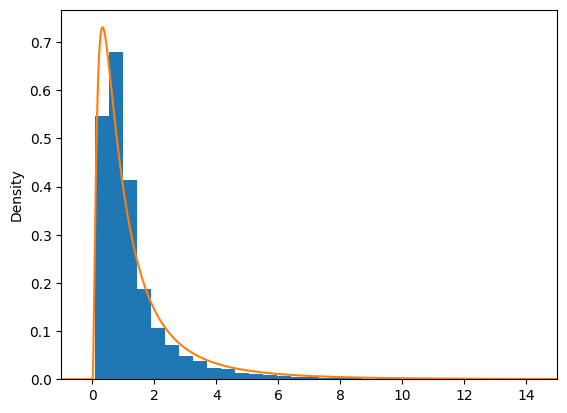

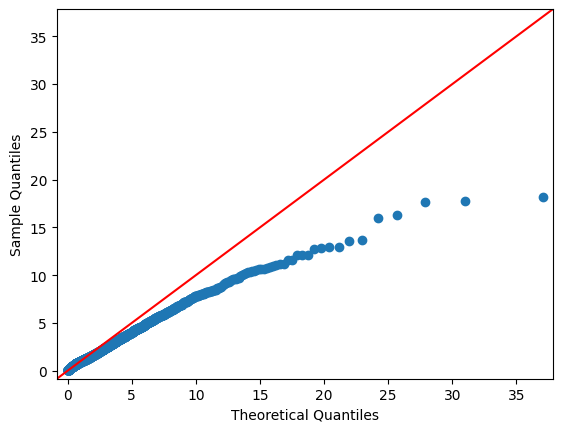

(1.4838491436301153, 3.7833271590819995, 6.184877138632554, 110.9363921763115)
1.2850819


In [178]:
np.random.seed(2)

x = np.random.uniform(-0.5,0.5,10000*N_input)
x = torch.tensor(x, dtype=torch.float32).reshape(10000, N_input)
X_predict = torch.tensor([0.6,0.3]*10000, dtype=torch.float32).reshape(10000,2)
X_predict = (X_predict) / X_stds
X_predict = torch.column_stack([X_predict,x])


with torch.no_grad():
    y_sample = model_Laplacian(X_predict)

y_sample = y_sample.reshape(1,-1).numpy()[0]
print(y_sample[1:10])

#real distribution
mylognorm = stats.lognorm(s = 1, scale = 0.9)

#quantiles
print(f'Real quantiles: {mylognorm.ppf([0.4,0.5,0.7,0.9,0.99,0.999])}')
print(f'Sample quantiles: {np.quantile(y_sample, [0.4,0.5,0.7,0.9,0.99,0.999])}')

#histogram
plt.hist(y_sample, bins = 40, density=True) 
x_axis = np.arange(-1, 70, 0.001) 
plt.plot(x_axis, mylognorm.pdf(x_axis))
plt.ylabel("Density")
plt.xlim(-1, 15)
plt.show()

#qq plot
sm.qqplot(y_sample, mylognorm, line = '45')
plt.show()

print(mylognorm.stats(moments='mvsk')) #mean, var, skew, kurt for real distribution
print(np.mean(y_sample)) #sample mean

Do generated sample distributions have lighter or heavier tails than the real distributions? 
Compare sample quantiles and real quantiles for x1 < 0.5 and x1 > 0.5 seperately

In [179]:
# x_1 < 0.5

np.random.seed(3)

n = 0
N_quantile_higher = 0

for i in np.arange(0.05,0.5,0.05):
    for j in np.arange(0.05,1,0.05):
        x = np.random.uniform(-0.5,0.5,1000*N_input)
        x = torch.tensor(x, dtype=torch.float32).reshape(1000, N_input)
        X_predict = torch.tensor([i,j]*1000, dtype=torch.float32).reshape(1000,2)
        X_predict = (X_predict) / X_stds
        X_predict = torch.column_stack([X_predict,x])
        with torch.no_grad(): #do not update the gradient 
            y_sample = model_Laplacian(X_predict)
        if i > 0.5: sigma = 1
        else: sigma = 0.5
        mylognorm = stats.lognorm(s = sigma, scale = i+j) #real distribution
        y_sample = y_sample.reshape(1,-1).numpy()[0]
        if np.quantile(y_sample, 0.99) > mylognorm.ppf(0.99) : N_quantile_higher += 1
        n+=1

print(N_quantile_higher/n)


0.4444444444444444


In [180]:
# 0.3 < x_1 < 0.5

np.random.seed(3)

n = 0
N_quantile_higher = 0

for i in np.arange(0.3,0.5,0.05):
    for j in np.arange(0.05,1,0.05):
        x = np.random.uniform(-0.5,0.5,1000*N_input)
        x = torch.tensor(x, dtype=torch.float32).reshape(1000, N_input)
        X_predict = torch.tensor([i,j]*1000, dtype=torch.float32).reshape(1000,2)
        X_predict = (X_predict) / X_stds
        X_predict = torch.column_stack([X_predict,x])
        with torch.no_grad(): #do not update the gradient 
            y_sample = model_Laplacian(X_predict)
        if i > 0.5: sigma = 1
        else: sigma = 0.5
        mylognorm = stats.lognorm(s = sigma, scale = i+j) #real distribution
        y_sample = y_sample.reshape(1,-1).numpy()[0]
        if np.quantile(y_sample, 0.999) > mylognorm.ppf(0.999) : N_quantile_higher += 1
        n+=1

print(N_quantile_higher/n)


0.9605263157894737


In [181]:
# x_1 < 0.3

np.random.seed(3)

n = 0
N_quantile_higher = 0

for i in np.arange(0.05,0.3,0.05):
    for j in np.arange(0.05,1,0.05):
        x = np.random.uniform(-0.5,0.5,1000*N_input)
        x = torch.tensor(x, dtype=torch.float32).reshape(1000, N_input)
        X_predict = torch.tensor([i,j]*1000, dtype=torch.float32).reshape(1000,2)
        X_predict = (X_predict) / X_stds
        X_predict = torch.column_stack([X_predict,x])
        with torch.no_grad(): #do not update the gradient 
            y_sample = model_Laplacian(X_predict)
        if i > 0.5: sigma = 1
        else: sigma = 0.5
        mylognorm = stats.lognorm(s = sigma, scale = i+j) #real distribution
        y_sample = y_sample.reshape(1,-1).numpy()[0]
        if np.quantile(y_sample, 0.999) > mylognorm.ppf(0.999) : N_quantile_higher += 1
        n+=1

print(N_quantile_higher/n)

0.23157894736842105


In [182]:
# x_1 > 0.5

np.random.seed(3)

n = 0
N_quantile_lower = 0

for i in np.arange(0.55,1,0.05):
    for j in np.arange(0.05,1,0.05):
        x = np.random.uniform(-0.5,0.5,1000*N_input)
        x = torch.tensor(x, dtype=torch.float32).reshape(1000, N_input)
        X_predict = torch.tensor([i,j]*1000, dtype=torch.float32).reshape(1000,2)
        X_predict = (X_predict) / X_stds
        X_predict = torch.column_stack([X_predict,x])
        with torch.no_grad(): #do not update the gradient 
            y_sample = model_Laplacian(X_predict)
        if i > 0.5: sigma = 1
        else: sigma = 0.5
        mylognorm = stats.lognorm(s = sigma, scale = i+j) #real distribution
        y_sample = y_sample.reshape(1,-1).numpy()[0]
        if np.quantile(y_sample, 0.999) < mylognorm.ppf(0.999) : N_quantile_lower += 1
        n+=1

print(N_quantile_lower/n)


1.0
